In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

1. Можно ли отобрать наиболее значимые признаки с помощью PCA?

In [2]:
class StandardScaler:
    def fit(self, X):
        self.means = X.mean(0)
        self.std = X.std(0)
    
    def transform(self, X):
        return (X - self.means) / self.std
    
    def inverse_transform(self, X):
        return X * self.std + self.means

In [3]:
def plot2D(X, y, feature_indexes:tuple):
    plt.figure()
    for c, i in zip("rgb", [0, 1, 2]):
        plt.scatter(X[y==i, feature_indexes[0]], X[y==i, feature_indexes[1]], c=c)
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title('PCA датасета')
    plt.show()

In [4]:
class PCA: 
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        self.max_features = X.shape[1]
        covariance_matrix = X.T.dot(X)
        eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
        self.eig = [(np.abs(eig), eig_vectors[:, i]) for i, eig in enumerate(eig_values)]
        eig_sum = sum(eig_values)
        self.explaned_variance_ratio = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
        self.eig.sort(key=lambda x: x[0], reverse=True)
        
    def transform(self, X):
        W = np.hstack([self.eig[i][1].reshape(self.max_features,1) for i in range(self.n_components)])
        return X.dot(W)

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
pca.fit(X_train_scaled)
Z_train = pca.transform(X_train_scaled)
Z_test = pca.transform(X_test_scaled)

In [7]:
pca.explaned_variance_ratio

[71.58179735625431, 23.72082736809803, 4.188111715453089, 0.5092635601945591]

На основе метода PCA, видно что первые 2 признака объясняют большую часть дисперсии в данных

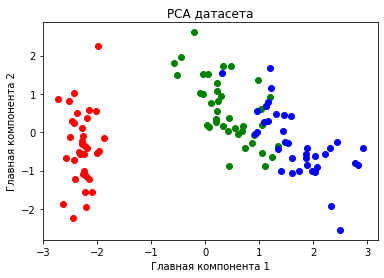

In [8]:
plot2D(Z_train, y_train, (0, 1))

Обучим модель логистической регрессии на попарных комбинациях признаков и сравним метрики

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [10]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled[:, :2], y_train)
print(classification_report(y_test, model.predict(X_test_scaled[:, :2])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.78      0.64      0.70        11
           2       0.71      0.83      0.77        12

    accuracy                           0.84        38
   macro avg       0.83      0.82      0.82        38
weighted avg       0.85      0.84      0.84        38



In [11]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled[:, 1:3], y_train)
print(classification_report(y_test, model.predict(X_test_scaled[:, 1:3])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



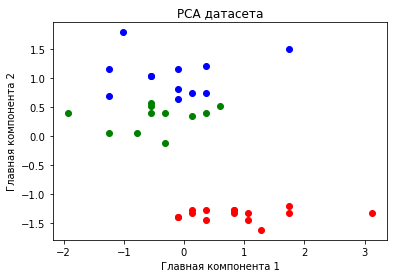

In [12]:
plot2D(X_test_scaled[:, 1:3], y_test, (0, 1))

* В случае обучения модели на признаках 1 и 3, классы полностью разделимы, в отличии от обучения на признаках 1 и 2. Следовательно метод PCA не может использоваться в качестве метода для отбора признаков. Так как скорее направлен на понижение размерности данных при максимально возможном описании их дисперсии.

(*) Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [13]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [14]:
for n_components in range(2, 4):
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    Z_train = pca.transform(X_train_scaled)
    Z_test = pca.transform(X_test_scaled)
    model = LogisticRegression(random_state=42)
    model.fit(Z_train, y_train)
    print('n_components=', n_components)
    print(classification_report(y_test, model.predict(Z_test)))

n_components= 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.90      0.82      0.86        11
           2       0.85      0.92      0.88        12

    accuracy                           0.92        38
   macro avg       0.92      0.91      0.91        38
weighted avg       0.92      0.92      0.92        38

n_components= 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



Метрики качества при применении PCA снижаются. На данном примере при снижении размерности до 3-х метрики остаются такими же как и без применения PCA

(*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [25]:
class PCA_SVD: 
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        self.max_features = X.shape[1]
        _, W, Vt = np.linalg.svd(X)
        self.eig = [(np.abs(w), v) for w, v in zip(W, Vt)]
        eig_sum = sum(W)
        self.explaned_variance_ratio = [(i / eig_sum) * 100 for i in sorted(W, reverse=True)]
        self.eig.sort(key=lambda x: x[0], reverse=True)
        
    def transform(self, X):
        W = np.hstack([self.eig[i][1].reshape(self.max_features,1) for i in range(self.n_components)])
        return X.dot(W)

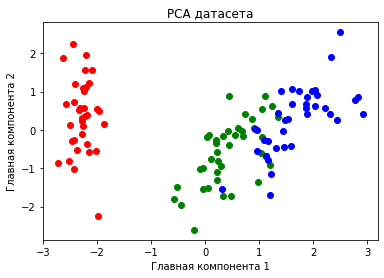

In [26]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA_SVD(n_components=2)
pca.fit(X_train_scaled)
Z_train = pca.transform(X_train_scaled)
Z_test = pca.transform(X_test_scaled)

plot2D(Z_train, y_train, (0, 1))